<a href="https://colab.research.google.com/github/aidamash/cage-aquaculture-mapping/blob/main/GEE_Export_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opening Patches exported through GEE

## Read the image patches exported

In [26]:
# Connect to Drive
from pathlib import Path
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#file_prefix = 'testPatches'
file_prefix = 'Sentinel2PatchExport'
# Create a path to the exported folder
path = Path('/content/drive/MyDrive/Google Earth/Sentinel2')

[f for f in path.iterdir() if file_prefix in f.stem]

[PosixPath('/content/drive/MyDrive/Google Earth/Sentinel2/Sentinel2PatchExport-mixer.json'),
 PosixPath('/content/drive/MyDrive/Google Earth/Sentinel2/Sentinel2PatchExport-00000.tfrecord.gz')]

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import json
#load the mixer json
json_file = str(path/(file_prefix+'-mixer.json'))
json_text = !cat "{json_file}"

mixer = json.loads(json_text.nlstr)
mixer

{'projection': {'crs': 'EPSG:4326',
  'affine': {'doubleMatrix': [8.983152841195215e-05,
    0.0,
    34.045610278959394,
    0.0,
    -8.983152841195215e-05,
    -0.06566684726913702]}},
 'patchDimensions': [100, 100],
 'patchesPerRow': 9,
 'totalPatches': 45}

In [40]:
# Get relevant info from the JSON mixer file.
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width, patch_height]
patch_dimensions_flat

[100, 100]

In [41]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'mndwi', 'ndwi']
image_columns = [
  tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32)
  for k in bands]

bands += ['classes']
image_columns += [tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.int64)]

# Parsing dictionary.
image_features_dict = dict(zip(bands, image_columns))
image_features_dict

{'B1': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B2': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B8A': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B9': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B11': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'B12': FixedLenFeature(shape=[100, 100], dtype=tf.float32, default_value=None),
 'mndwi': FixedLenFeature(shape=[100,

In [42]:
# Parsing function.
def parse_image(example_proto):
  return tf.io.parse_single_example(example_proto, image_features_dict)

In [43]:
# Note that you can make one dataset from many files by specifying a list.
image_dataset = tf.data.TFRecordDataset(str(path/(file_prefix+'-00000.tfrecord.gz')), compression_type='GZIP')
ds = image_dataset.map(parse_image, num_parallel_calls=5)
ds

<_ParallelMapDataset element_spec={'B1': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B11': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B12': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B2': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B5': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B6': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B7': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B8': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B8A': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'B9': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'classes': TensorSpec(shape=(100, 100), dtype=tf.int64, name=None), 'mndwi': TensorSpec(shape=(100, 100), dtype=tf.float32, name=None), 'ndwi': TensorSpec(shape=(100, 100), dtype=tf.

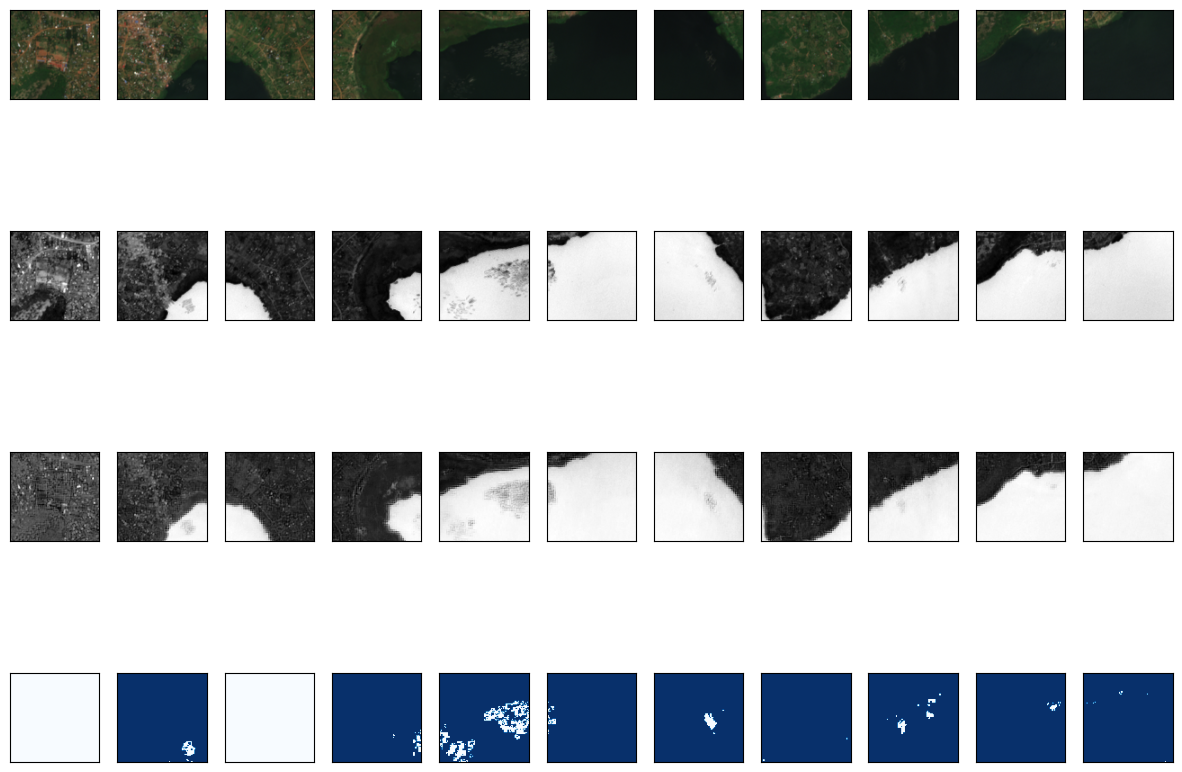

In [74]:
def plot_patch(ax, arr, cmap=None):
  ax.imshow(arr, cmap=cmap)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(4, 11, figsize=(15,11))

for i, idx in enumerate([0,1,2,3,4,5,6,7,8,9,10]): #[66, 74, 83, 93, 112, 123]):
  img = list(ds.as_numpy_iterator())[idx]
  rgb = np.concatenate((img['B4'][..., None], img['B3'][..., None], img['B2'][..., None]), axis=2)

  plot_patch(ax[0,i], rgb*3)
  plot_patch(ax[1,i], img['ndwi'], 'Greys_r')
  plot_patch(ax[2,i], img['mndwi'], 'Greys_r')
  plot_patch(ax[3,i], img['classes'], 'Blues')